## Config

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions.dsb2017 import dsbconfig as comp;
import dicom
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from nbpapaya import Brain, clear_brain, Brain, Surface, Overlay
import SimpleITK as sitk
import csv
import xml
from bs4 import BeautifulSoup

In [ ]:
PROJECT_PATH = os.path.join('/bigguy/data/luna')
DATA_PATH = os.path.join('/bigguy/data/luna/data')
META_PATH = os.path.join(PROJECT_PATH, 'csv')
EXTRACTED_IMG_PATH = os.path.join(PROJECT_PATH, 'extracted_imgs')
EXTRACTED_LABEL_PATH = os.path.join(PROJECT_PATH, 'extracted_labels')
ANNOTATIONS_PATH = os.path.join(META_PATH, 'annotations.csv')
LIDC_ANNO_PATH = os.path.join(META_PATH, 'lidc_annotations')
MEAN_PIXEL_VALUE_NODULE = 41
SEGMENTER_IMG_SIZE = 320
TARGET_VOXEL_MM = 1.00
VOXEL_SPACING = [TARGET_VOXEL_MM, TARGET_VOXEL_MM, TARGET_VOXEL_MM]
subset_path = os.path.join(DATA_PATH, 'subset0')
fpaths = glob(subset_path+"/*.mhd")

In [ ]:
"""
http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/21_Transforms_and_Resampling.html
https://github.com/dhammack/DSB2017/blob/master/training_code/DLung/data_generator_fn.py
https://github.com/juliandewit/kaggle_ndsb2017/blob/master/step1_preprocess_luna16.py
https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing/notebook
https://github.com/booz-allen-hamilton/DSB3Tutorial
https://gist.github.com/ajsander/ea33b90cc6fcff2696cd3b350ed7f86c
https://github.com/juliandewit/kaggle_ndsb2017/blob/master/step1b_preprocess_make_train_cubes.py
https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI#96d911248b584775bb65cdd4a4883550
https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/
https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks
https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/03_Image_Details.ipynb
https://github.com/nipy/nibabel
https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/
""";

## Kaggle

In [ ]:
"""
http://pydicom.readthedocs.io/en/stable/getting_started.html
https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/notebook
https://www.kaggle.com/c/data-science-bowl-2017
https://github.com/lfz/DSB2017
http://nbviewer.jupyter.org/github/bckenstler/dsb17-walkthrough/blob/master/Part%201.%20DSB17%20Preprocessing.ipynb
https://www.youtube.com/watch?v=BmkdAqd5ReY (Intro to CT scans)
http://www.dspguide.com/ch25/5.htm
""";

In [ ]:
patients = sorted(os.listdir(cfg.SAMPLE_IMAGE_PATH))

In [ ]:
# Load the scans in given 'patient' dir
# One directory is one scan of multiple slices
# We calculate the pixel size in the Z direction (slice thickness), since not provided
# Returns list of slices (dicom format)
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

In [ ]:
patient_idx = random.randint(0,len(patients))
patient_path = os.path.join(cfg.SAMPLE_IMAGE_PATH, patients[patient_idx])
patient_fnames, pat_fpaths = utils.files.get_paths_to_files(patient_path)
scan1 = load_scan(patient_path)

In [ ]:
# Metadata
scan1

In [ ]:
# Convert to Hounsfield Units (HU)
# Unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.
# Radiodensity - measurement of how absorbent a material is to X-rays. This naturally differs for different materials, so by measuring this we have a way of visualizing the interior tissues and so forth.
# Convert to HU by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

# Returns np array of slices in HUs
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
first_patient_scan = load_scan(patient_path)
first_patient_pixels = get_pixels_hu(first_patient_scan)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [ ]:
"""
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.
"""

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
first_patient_resampled_img, resample_spacing = resample(first_patient_pixels, first_patient_scan)
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", first_patient_resampled_img.shape)

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
plot_3d(first_patient_resampled_img, 400)

In [ ]:
## Lung Segmentation

"""
1) Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
2) Do connected components, determine label of air around person, fill this with 1s in the binary image
3) Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
4) Keep only the largest air pocket (the human body has other pockets of air here and there).
""";

In [ ]:
"""
Normalization --

Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:

Zero Centering --

Zero center your data so that your mean value is 0. Subtract the mean pixel value from all pixels. To determine this mean you simply average all images in the whole dataset. If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition.

* DO NOT zero center with the mean per `image`
"""

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [ ]:
"""
Run Pre-processing Tonight!!

To save storage space, don't do normalization and zero centering beforehand, but do this online (during training, just after loading)
"""

## Luna

### Annotation Schemas

In [ ]:
# LIDC
# https://wiki.cancerimagingarchive.net/download/attachments/3539039/LIDC_XML_Documentation_1_Jan_2009.doc?version=1&modificationDate=1319224566057&api=v2
"""
The LIDC used a two phase reading process. In the first phase, multiple readers (N=4 as of Jan 2006), read and annotated each case independently in a blinded fashion.  That is, they all read the same cases, but they the readings were done asynchronously and independently.  After the results of that first, blinded reading were complete, they were compiled and sent back out to the same readers so that they could see both their own markings as well as the markings from the other three readers.  Each reader then, again independently, read each case, this time with the benefit of information as to what other readers saw/marked, and then made a final decisions about the markings for that case.

3 step annotation process:
1) Blind read by 4 radiologists
2) Each radiologist showed the annotations of the others
3) Unblind read by 4 radiologists

IMAGES ONLY INCLUDE THE 2nd Unblinded Read

Interesting!!
Malignancy - Radiologist subjective assessment of likelihood of malignancy of this nodule, ASSUMING  60-year-old male smoker 

3 Types of Annotations:
1) Nodules >= 3mm diameter 
    - Complete outline (segmentation)
    - Include characteristics (e.g. malignancy)
2) Nodules < 3mm diameter 
    - Center of mass labeled (x,y,z)
    - Do not include characteristics
3) Non-Nodules > 3mm  diameter
    - Center of mass labeled (x,y,z)
    - Do not include characteristics

* Non-Nodules < 3mm were NOT marked! (might confuse the model)

Terms
-----
* Scan files = 158.xml, 162.xml..
* SeriesInstanceUid = Patient
* StudyInstanceUID = Scan 
* nodule id – a unique id for the nodule marked by this reader
* Nodule Contour ROI – this is the description of the complete three dimensional contour of the nodule (remembering that the radiologist was instructed to mark the first voxel outside the nodule)
* Inclusion – “True” means that the roi that follows is considered part of the nodule; “False” means that the roi that follows should be subtracted from the nodule.
* Locus – is unique to non-nodules (and is used in place of “edge map”) and indicates that the indicator point of the non-nodule is to follow:
<locus>				beginning of non-nodule description
<xCoord>215</xCoord>		x coordinate location of non-nodule
<yCoord>312</yCoord>		y coordinate location of non-nodule
</locus>				end of non-nodule description


<SeriesInstanceUid>1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824</SeriesInstanceUid>
<StudyInstanceUID>1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432</StudyInstanceUID>


* Nodules >= 3mm diameter 

 <unblindedReadNodule>
   <noduleID>6</noduleID>
   <characteristics>
    <subtlety>5</subtlety>
    <internalStructure>1</internalStructure>
    <calcification>4</calcification>
    <sphericity>3</sphericity>
    <margin>5</margin>
    <lobulation>2</lobulation>
    <spiculation>3</spiculation>
    <texture>5</texture>
    <malignancy>4</malignancy>
   </characteristics>
   
   ## ROIS are the same nodule on different slices
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
 </unblindedReadNodule>
 
 
 
* Nodules < 3mm diameter 

  <unblindedReadNodule>
   <noduleID>5</noduleID>
   <roi>
    <imageZposition>1631.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.349696112719071080933041621585</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>197</xCoord><yCoord>321</yCoord></edgeMap>
   </roi>
  </unblindedReadNodule>



* Non-Nodules > 3mm  diameter:

  <nonNodule>
   <nonNoduleID>2058</nonNoduleID>
   <imageZposition>1628.5</imageZposition>
   <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.216194661683946632889617404306</imageSOP_UID>
   <locus>
    <xCoord>199</xCoord><yCoord>320</yCoord>
   </locus>
  </nonNodule>
"""


In [ ]:
def find_mhd_file(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def load_lidc_xml(xml_path, agreement_threshold=0, only_patient=None, save_nodules=False):
    """
    Writes 2 CSV files with nodule and non-nodule annotations
        - nodules >= 3mm
        - non-nodules
    Nodule annotations include: id, z, y, x, diameter, malignancy
    Coords and Diameter are stored as percent of image size
    Diameter is calculated as the max of x and y
        - We reduce irregularly shaped nodules into circles (boxes)
    Optionally include only nodules with radiologist agreement
    Ignores nodules < 3mm
    """
    pos_lines = []
    neg_lines = []
    extended_lines = []
    
    # Each LIDC xml file represents a read of a single 3D CT Scan (multiple slices)
    with open(xml_path, 'r') as xml_file:
        markup = xml_file.read()
    xml = BeautifulSoup(markup, features="xml")
    
    # Catch corrupt files
    if xml.LidcReadMessage is None:
        return None, None, None
    
    patient_id = xml.LidcReadMessage.ResponseHeader.SeriesInstanceUid.text

    # Option to filter for single patient
    if only_patient is not None:
        if only_patient != patient_id:
            return None, None, None

    # Load the CT Scan image by patient_id
    src_path = find_mhd_file(patient_id)
    if src_path is None:
        return None, None, None

    print(patient_id)
    
    # Load the CT Scan with SimpleITK
    # This a 3D volume containing multiple 2D slices
    itk_img = sitk.ReadImage(src_path)
    
    # Convert to Numpy (z, 512, 512)
    img_array = sitk.GetArrayFromImage(itk_img)
    
    # z,y,x (height before width)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    
    # Needed to calculate offet and normalize
    # Follow-up on this..
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    
    # 1.00 is a hyperparameter 
    # Rescale so that every voxel represents an volume of 1x1x1 mm
    # Needed to ensure consistency across scans
    rescale = spacing / 1.00 #1x1x1

    # Up to 4 per scan, one per radiologist
    reading_sessions = xml.LidcReadMessage.find_all("readingSession")
    
    # A reading session is all slices in CT Scan read by one radiologist
    for reading_session in reading_sessions:
        
        # Get the list of nodules (since up to 4 reads, many will identify the same nodule)
        nodules = reading_session.find_all("unblindedReadNodule")

        # Includes both >= 3 (characteristics and outline) and <3 (just the centroid)
        for nodule in nodules:
            nodule_id = nodule.noduleID.text # e.g. 1823
            
            # Same nodule appears in multiple slices (3D)
            rois = nodule.find_all("roi")
            
            # To creat the annotations we're going to find the edges
            # of the outline, calculate the center
            # then use the diameter to segment?
            x_min = y_min = z_min = 999999
            x_max = y_max = z_max = -999999
            
            # Skip nodules < 3mm (they only have 1 point (x,y) marked on 1 slicet (the center))
            if len(rois) < 2:
                continue

            # For each slice in nodule >= 3mm
            for roi in rois:
                
                # If Z is < ZMin or >ZMax, update
                z_pos = float(roi.imageZposition.text)
                z_min = min(z_min, z_pos)
                z_max = max(z_max, z_pos)
                
                # Edge maps are single points (x,y) in the outline
                edge_maps = roi.find_all("edgeMap")
                for edge_map in edge_maps:
                    x = int(edge_map.xCoord.text)
                    y = int(edge_map.yCoord.text)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)
                
                # Catching an edge case 
                # where annotations are crap
                if x_max == x_min:
                    continue
                if y_max == y_min:
                    continue

            # Calculate the diameter + center
            x_diameter = x_max - x_min
            x_center = x_min + x_diameter / 2
            y_diameter = y_max - y_min
            y_center = y_min + y_diameter / 2
            z_diameter = z_max - z_min
            z_center = z_min + z_diameter / 2
            
            # Adjust the center based on origin + spacing
            # Since each scan taken by different machine there
            # is variation..
            z_center -= origin[2]
            z_center /= spacing[2]

            # Calculate the percent (normalized location) of the center
            # with respect to the image size
            # Why?
            # Why are y and x backwards? I thought x would come first....
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Set the diameter to the max of x, y
            # This simplifies the annotation by ignoring ovals 
            # and non-circular nodules..
            diameter = max(x_diameter , y_diameter)
            
            # What percentage is the nodule size of the whole image..
            diameter_perc = round(max(x_diameter / img_array.shape[2], y_diameter / img_array.shape[1]), 4)

            # Skip nodules with important missing fields
            if nodule.characteristics is None:
                print("!!!!Nodule:", nodule_id, " has no charecteristics")
                continue
            if nodule.characteristics.malignancy is None:
                print("!!!!Nodule:", nodule_id, " has no malignacy")
                continue

            # Extract characteristics
            malignacy = nodule.characteristics.malignancy.text
            sphericiy = nodule.characteristics.sphericity.text
            margin = nodule.characteristics.margin.text
            spiculation = nodule.characteristics.spiculation.text
            texture = nodule.characteristics.texture.text
            calcification = nodule.characteristics.calcification.text
            internal_structure = nodule.characteristics.internalStructure.text
            lobulation = nodule.characteristics.lobulation.text
            subtlety = nodule.characteristics.subtlety.text

            # "line" is the primary one we use for model
            # We save the x,y,z,diameter percent relative to image size 
            line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            extended_line = [patient_id, nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc,
                             malignacy, sphericiy, margin, spiculation, texture, calcification,
                             internal_structure, lobulation, subtlety ]
            
            # Since this is a nodule >= 3mm, we add this to our list of nodules (TPs)
            pos_lines.append(line)
            
            # Only includes nodules >= 3mm with all attributes
            extended_lines.append(extended_line)

        # Non-Nodules > 3mm  diameter
        # We only have a single z,y,x point for these
        nonNodules = reading_session.find_all("nonNodule")
        for nonNodule in nonNodules:
            z_center = float(nonNodule.imageZposition.text)
            
            # Adjust for offset
            z_center -= origin[2]
            z_center /= spacing[2]
            x_center = int(nonNodule.locus.xCoord.text)
            y_center = int(nonNodule.locus.yCoord.text)
            nodule_id = nonNodule.nonNoduleID.text
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Why 6??????
            diameter_perc = round(max(6 / img_array.shape[2], 6 / img_array.shape[1]), 4)
            
            # Add to list of non-nodules (TNs)
            # line = nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, 0]
            neg_lines.append(line)

    # Option to ignore nodules where
    # multiple radiologists did NOT agree
    if agreement_threshold > 1:
        filtered_lines = []
        
        # Loop through all the nodules
        for pos_line1 in pos_lines:
            id1 = pos_line1[0]
            x1 = pos_line1[1]
            y1 = pos_line1[2]
            z1 = pos_line1[3]
            d1 = pos_line1[4]
            overlaps = 0
            
            # Loop through all nodules again
            for pos_line2 in pos_lines:
                id2 = pos_line2[0]
                
                # Skip the original nodule
                if id1 == id2:
                    continue
                x2 = pos_line2[1]
                y2 = pos_line2[2]
                z2 = pos_line2[3]
                d2 = pos_line1[4]
                
                # Gets the area of overlap???????
                # TODO WHAT does this do..
                dist = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2) + math.pow(z1 - z2, 2))

                # If the combined area is less than one or the other
                # Then this is an overlap (>1 radiologists agree)
                if dist < d1 or dist < d2:
                    overlaps += 1
            
            # Add nodule if more than one radiologist agrees
            if overlaps >= agreement_threshold:
                filtered_lines.append(pos_line1)

        # Only overlapping nodule annotations become nodules
        pos_lines = filtered_lines

    # Create DF of all nodules for this CT scan
    df_annos = pd.DataFrame(
        pos_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_annos.to_csv(os.path.join(EXTRACTED_LABEL_PATH, patient_id + "_annos_pos_lidc.csv"), index=False)

    # Create DF of all non-nodules for this CT scan
    df_neg_annos = pd.DataFrame(
        neg_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_neg_annos.to_csv(os.path.join(EXTRACTED_LABEL_PATH, patient_id + "_annos_neg_lidc.csv"), index=False)

    # We've now saved two csv files for each scan (patient read)
    # one for nodules and one for non-nodules
    return pos_lines, neg_lines, extended_lines


def process_lidc_annotations(only_patient=None, agreement_threshold=0):
    """
    Save nodule and non-nodule annotations for each scan
    Save all nodule >= 3mm annotations to single master file
    By default, we include overlapping annotations from multiple radiologists
    This means the same nodule will show up twice or more
    Agreement=0, returns about 5900 nodules
    """
    file_no = 0
    pos_count = 0
    neg_count = 0
    all_lines = []
    
    # Loop through all the LIDC annotation files (one per CT scan)
    # Each includes up to 4 radiologist reading sessions
    for anno_dir in [d for d in glob(LIDC_ANNO_PATH+"/*") if os.path.isdir(d)]:
        xml_paths = glob(anno_dir + "/*.xml")
        for xml_path in xml_paths:
            print(file_no, ": ",  xml_path)
            
            # This method saves the individual CSVs per scan
            pos, neg, extended = load_lidc_xml(
                xml_path=xml_path, only_patient=only_patient, 
                agreement_threshold=agreement_threshold)
            
            # Function returns None if only one scan requested
            if pos is not None:
                pos_count += len(pos)
                neg_count += len(neg)
                print("Pos: ", pos_count, " Neg: ", neg_count)
                file_no += 1
                all_lines += extended

    # Save all nodules >= 3mm
    # Nodules < 3mm are ignored
    df_annos = pd.DataFrame(all_lines, columns=["patient_id", "anno_index", "coord_x", "coord_y", "coord_z", "diameter",
                                                "malscore", "sphericiy", "margin", "spiculation", "texture", "calcification",
                                                "internal_structure", "lobulation", "subtlety"])
    df_annos.to_csv(os.path.join(META_PATH, "lidc_annotations.csv"), index=False)

In [ ]:
process_lidc_annotations()

In [ ]:
lidc_pos_df = pd.read_csv(os.path.join(META_PATH, "lidc_annotations.csv"))

In [ ]:
patient_id = lidc_pos_df.iloc[100].patient_id
all_patient_nodules = lidc_pos_df[lidc_pos_df.patient_id == patient_id]  # same result as the previous expression
coord_z_w_patient_nodules = all_patient_nodules['coord_z'].values
coord_z = coord_z_w_patient_nodules[0]
print(coord_z)
single_slice_patient_nodules = all_patient_nodules.loc[(all_patient_nodules["coord_z"] == coord_z) & (all_patient_nodules["patient_id"] == patient_id)]

### Process Luna

In [ ]:
def resample_img(img_arr, old_spacing, new_spacing):    
    resize_factor = old_spacing / new_spacing
    print("Resize", resize_factor)
    new_real_shape = img_arr.shape * resize_factor
    print("New shape", new_real_shape)
    new_shape = np.round(new_real_shape)
    print("New shape", new_real_shape)
    real_resize_factor = new_shape / img_arr.shape
    print("Real resize", new_real_shape)
    new_spacing = old_spacing / real_resize_factor
    print("New spacing", new_real_shape)
    image = scipy.ndimage.interpolation.zoom(
        img_arr, real_resize_factor, mode = 'nearest')
    return image, new_spacing


def process_luna_img():
    pass

In [244]:
anno_df = pd.read_csv(os.path.join(META_PATH, "annotations.csv"))
print(anno_df.columns)
anno_df.columns = ['patient_id', 'coord_x', 'coord_y', 'coord_z', 'diameter']
patient_idx = 5
patient_id = lidc_pos_df.iloc[patient_idx].patient_id
print ("Patient Id", patient_id)
img_fpath = get_mhd_path_from_patient_id(patient_id)
img_arr, origin, spacing = load_arr_from_mhd(img_fpath)
print("Old img", img_arr.shape, origin, spacing)

# Rescale Image
img_arr, spacing = resample_img(img_arr, spacing, VOXEL_SPACING)

Index(['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm'], dtype='object')
Patient Id 1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561
Old img (141, 512, 512) [-413.25     -196.600006 -180.      ] [ 2.5       0.703125  0.703125]
Resize [ 2.5       0.703125  0.703125]
New shape [ 352.5  360.   360. ]
New shape [ 352.5  360.   360. ]
Real resize [ 352.5  360.   360. ]
New spacing [ 352.5  360.   360. ]


In [ ]:
plot_slice(img_arr[100,:,:])

In [ ]:
# Normalize Image
img_arr = normalize(img_arr)
print("New img", img_arr.shape, origin, spacing)
plot_slice(img_arr[100,:,:])

In [ ]:
#%ls /bigguy/data/luna/data/subset0/

In [265]:
patient_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987'
img_path = os.path.join(DATA_PATH, 'subset0', patient_id+'.mhd')
print(img_path)
itk_img = sitk.ReadImage(img_path)
img_arr, origin, spacing = load_arr_from_mhd(img_path)
print("Shape", img_arr.shape, "Origin", origin, "Spacing", spacing)

itk_img.GetDepth(), itk_img.GetHeight(), itk_img.GetWidth(), itk_img.GetOrigin(), itk_img.GetSpacing()
print("Size", itk_img.GetSize()) #(x,y,z)
print("Direction", itk_img.GetDirection())
img_arr = sitk.GetArrayFromImage(itk_img)
img_arr.shape #(z,y,x)
rescale = spacing / TARGET_VOXEL_MM
print("Rescale", rescale)

def resample(image, old_spacing, new_spacing=[1, 1, 1]):    
    resize_factor = old_spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = old_spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode = 'nearest')
    
    return image, new_spacing

# img_arr, new_spacing = resample(img_arr, spacing)
# img_arr.shape

/bigguy/data/luna/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Shape (538, 512, 512) Origin [-298.774994 -143.100006 -180.600006] Spacing [ 0.625       0.74218798  0.74218798]
Size (512, 512, 538)
Direction (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Rescale [ 0.625       0.74218798  0.74218798]


In [ ]:
TARGET_VOXEL_MM = [1.,1.,1.]
nodules = anno_df[anno_df.patient_id == patient_id]
print(nodules.columns)
assert nodules['patient_id'].values[0] == patient_id
nodule = nodules.values[0]
nodule_z, nodule_y, nodule_x = nodule[3], nodule[2], nodule[1]
nodule_coords = nodule[1:4]
print("Init Nodule coords", nodule_coords, nodule_z, nodule_y, nodule_x)
nodule_coords = np.array([nodule_z, nodule_y, nodule_x])
print("Reversed Nodule coords", nodule_coords, nodule_z, nodule_y, nodule_x)
new_nodule_coords = world_2_voxel(nodule_coords, origin, spacing)
print(np.ceil(new_nodule_coords).astype(int))

/bigguy/data/luna/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Shape (538, 512, 512) Origin [-298.774994 -143.100006 -180.600006] Spacing [ 0.625       0.74218798  0.74218798]
Index(['patient_id', 'coord_x', 'coord_y', 'coord_z', 'diameter'], dtype='object')
Init Nodule coords [136.43405869999998 117.76557890000001 -181.94781709999998] -181.94781709999998 117.76557890000001 136.43405869999998
Reversed Nodule coords [-181.9478171  117.7655789  136.4340587] -181.94781709999998 117.76557890000001 136.43405869999998
[187 352 428]
(427, 351)


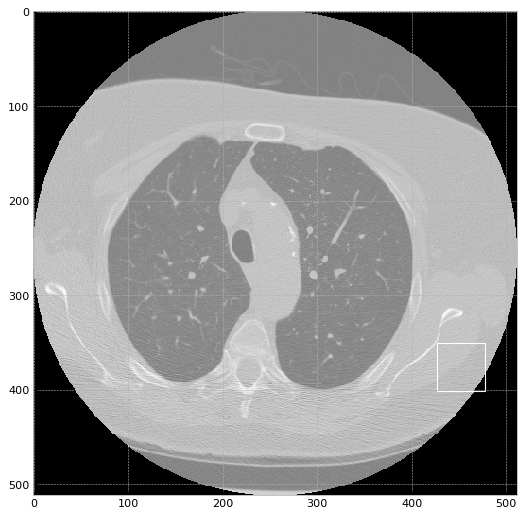

In [251]:
margin=0.05
dpi=80
npa_zslice = scan_arr[187,:,:]
ysize = npa_zslice.shape[0]
xsize = npa_zslice.shape[1]
figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
fig = plt.figure(figsize=(figsize), dpi=dpi)
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
t = ax.imshow(npa_zslice, interpolation=None)
xy = int(round(new_nodule_coords[2])),round(int(new_nodule_coords[1]))
print(xy)
box = plt.Rectangle(xy, 50, 50, fill=False, 
                    edgecolor='white', linewidth=1)
ax.add_patch(box)
plt.imshow(npa_zslice, cmap=plt.cm.Greys_r, 
           vmin=npa_zslice.min(), vmax=npa_zslice.max());

In [ ]:
npa_zslice = scan_arr[100,:,:]
ysize = npa_zslice.shape[0]
xsize = npa_zslice.shape[1]
#fig = plt.figure()
#fig.set_size_inches(15,30)

figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
t = ax.imshow(npa_zslice, interpolation=None)
box = plt.Rectangle((100,100), 50, 50, fill=False, 
                    edgecolor='white', linewidth=1)
ax.add_patch(box)
# if 'score' in bbox:
#     text = '%s: %.2f' % (bbox['label'], bbox['score'])
# else:
#     text = bbox['label']
ax.text(100, 100, text, 
        bbox={'facecolor':'white', 'alpha':0.5})
        
plt.imshow(npa_zslice, cmap=plt.cm.Greys_r, 
           vmin=scan_arr.min(), vmax=scan_arr.max());
plt.title(title)

In [ ]:
# Get Nodules
nodules = anno_df[anno_df.patient_id == patient_id]

def create_bb(z, y, x, diameter, label="nodule"):
    radius = diameter/2.0
    return {
        'label': label,
        'slice': z,
        'diameter': diameter,
        'xmin': int(round(x - radius)),
        'ymin': int(round(y - radius)),
        'xmax': int(round(x + radius)),
        'ymax': int(round(y + radius))
    }

bbs = []
for index, nodule in nodules.iterrows():
    z,y,x = nodule['coord_z'], nodule['coord_y'], nodule['coord_z']
    diameter = nodule['diameter']
    print("Old anno", z,y,x,diameter)
    
    # Rescale Annotation
    z,y,x = world_2_voxel((z,y,x), origin, spacing)
    z,y,x = int(round(z)), int(round(y)), int(round(x))
    #z,y,x = int(coords[0]),int(coords[1]),int(coords[2])
    #z,y,x = int(round(z)), int(round(y)), int(round(x))
    print("New anno", z,y,x)
    bb = create_bb(z,y,x, diameter)
    print(bb)
    bbs.append(bb)
    
print("imgshape coords", img_arr.shape, z,y,x)
print("Bounding Boxes:", bbs)

In [ ]:
bb_idx = 0
slice_idx = bbs[bb_idx]['slice']
print("Slice", slice_idx)
print("BB", bbs[bb_idx:bb_idx+1])
plot_slice_bbs(img_arr[slice_idx], bbs[bb_idx:bb_idx+1])

In [ ]:
margin = 0.05
dpi = 80
title = "slice1"
text = "nodule0"

npa_zslice = scan_arr[100,:,:]
ysize = npa_zslice.shape[0]
xsize = npa_zslice.shape[1]
#fig = plt.figure()
#fig.set_size_inches(15,30)

figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
t = ax.imshow(npa_zslice, interpolation=None)
box = plt.Rectangle((100,100), 50, 50, fill=False, 
                    edgecolor='white', linewidth=1)
ax.add_patch(box)
# if 'score' in bbox:
#     text = '%s: %.2f' % (bbox['label'], bbox['score'])
# else:
#     text = bbox['label']
ax.text(100, 100, text, 
        bbox={'facecolor':'white', 'alpha':0.5})
        
plt.imshow(npa_zslice, cmap=plt.cm.Greys_r, 
           vmin=scan_arr.min(), vmax=scan_arr.max());
plt.title(title)

In [ ]:
anno_df.columns, lidc_pos_df.columns

In [ ]:
lidc_pos_df = pd.read_csv(os.path.join(META_PATH, "lidc_annotations.csv"))
luna_pos_df = pd.read_csv(os.path.join(META_PATH, "annotations.csv"))

luna_pos_df

### Visualize 2D

In [ ]:
"""
SimpleITK convention = z,y,z
Spacing = # of pixels between axis (e.g. how many pixels between slices? z,y,z all have spacing)
Origin = Starting point from which ..... ??

SimpleITK and numpy indexing access is in opposite order!
SimpleITK: image[x,y,z]
numpy: image_numpy_array[z,y,x]

GetArrayFromImage(): returns a copy of the image data. You can then freely modify the data as it has no effect on the original SimpleITK image.

GetArrayViewFromImage(): returns a view on the image data which is useful for display in a memory efficient manner. You cannot modify the data and the view will be invalid if the original SimpleITK image is deleted.

http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html
"""

In [ ]:
def plot_slice(slice_arr):
    fig = plt.figure()
    fig.set_size_inches(15,30)
    plt.title('Slice1')
    plt.imshow(slice_arr, cmap=plt.cm.Greys_r, 
               vmin=slice_arr.min(), vmax=slice_arr.max());

COLORS = {
    'nodule': 'white',
    'non_nodule': 'red'
}

def plot_slice_bbs(slice_arr, bboxes, margin=0.05, dpi=80, title="slice"):
    print("Slice Shape", slice_arr.shape)
    ysize = slice_arr.shape[0]
    xsize = slice_arr.shape[1]
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    #fig.set_size_inches(15,30)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)    
    t = ax.imshow(slice_arr, extent=extent, interpolation=None)
    plt.imshow(slice_arr, cmap=plt.cm.Greys_r, 
               vmin=slice_arr.min(), vmax=slice_arr.max());
        
    for bbox in bboxes:
        print(bbox)
        xy = bbox['xmin'], bbox['ymin']
        width = bbox['xmax'] - bbox['xmin']
        height = bbox['ymax'] - bbox['ymin']
        color = COLORS[bbox['label']]
        box = plt.Rectangle(xy, width, height, fill=False, 
                            edgecolor=color, linewidth=1)
        ax.add_patch(box)
        if 'score' in bbox:
            text = '%s: %.2f' % (bbox['label'], bbox['score'])
        else:
            text = bbox['label']
        ax.text(bbox['xmin'], bbox['ymin'], text, 
                bbox={'facecolor':color, 'alpha':0.5})
    plt.title(title)
    

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def get_mhd_path_from_patient_id(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def load_arr_from_mhd(filename):
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return ct_scan, origin, spacing

def load_viewable_arr_from_mhd(filename):
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayViewFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return ct_scan, origin, spacing

def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def resize_voxel(x, desired_shape):
    factors = np.array(x.shape).astype('float32') / np.array(desired_shape).astype('float32')
    output= ndimage.interpolation.zoom(x,1.0 / factors,order=1)
    assert output.shape == desired_shape, 'resize error'
    return output

def percent_to_pixels(x_perc, y_perc, z_perc, img):
    res_x = int(round(x_perc * img.shape[2]))
    res_y = int(round(y_perc * img.shape[1]))
    res_z = int(round(z_perc * img.shape[0]))
    return res_x, res_y, res_z

In [227]:
lidc_pos_df = pd.read_csv(os.path.join(META_PATH, "lidc_annotations.csv"))
luna_pos_df = pd.read_csv(os.path.join(META_PATH, "annotations.csv"))


patient_id = lidc_pos_df.iloc[100].patient_id
mhd_path = get_mhd_path_from_patient_id(patient_id)
itk_img = sitk.ReadImage(mhd_path)

print("ITK Image")
print("Origin", itk_img.GetOrigin())
print("Size", itk_img.GetSize())
print("Spacing", itk_img.GetSpacing())
print("Direction", itk_img.GetDirection())
print(itk_img.GetDimension())
print(itk_img.GetWidth())
print(itk_img.GetHeight())
print(itk_img.GetDepth())



# Get Numpy Array from SimpleITK format
scan_arr, origin, spacing = load_arr_from_mhd(mhd_path)
viewable_scan_arr, origin, spacing = load_viewable_arr_from_mhd(mhd_path)

ITK Image
Origin (-165.399994, -141.399994, -328.244995)
Size (512, 512, 240)
Spacing (0.6035159826278687, 0.6035159826278687, 1.25)
Direction (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
3
512
512
240


In [229]:
# itk_img = SimpleITK.ReadImage(src_path)
# img_array = SimpleITK.GetArrayFromImage(itk_img)
# num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
# origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
# spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
# rescale = spacing / settings.TARGET_VOXEL_MM

In [ ]:
npa_zslice = scan_arr[100,:,:]
fig = plt.figure()
fig.set_size_inches(15,30)

fig.add_subplot(1,3,1)
plt.imshow(npa_zslice)
plt.title('default colormap')
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r);
plt.title('grey colormap')
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('grey colormap,\n scaling based on volumetric min and max values')
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r, vmin=scan_arr.min(), vmax=scan_arr.max())
plt.axis('off');

In [ ]:
npa_zslice = scan_arr[100,:,:]
fig = plt.figure()
fig.set_size_inches(15,30)
plt.title('Slice1')
plt.imshow(npa_zslice, cmap=plt.cm.Greys_r, 
           vmin=scan_arr.min(), vmax=scan_arr.max());

In [ ]:
margin = 0.05
dpi = 80
title = "slice1"
text = "nodule0"
spacing = itk_img.GetSpacing()

npa_zslice = scan_arr[100,:,:]
ysize = npa_zslice.shape[0]
xsize = npa_zslice.shape[1]
#fig = plt.figure()
#fig.set_size_inches(15,30)

figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
extent = (0, xsize*spacing[1], ysize*spacing[0], 0)    
t = ax.imshow(npa_zslice, extent=extent, interpolation=None)
box = plt.Rectangle((100,100), 50, 50, fill=False, 
                    edgecolor='white', linewidth=1)
ax.add_patch(box)
# if 'score' in bbox:
#     text = '%s: %.2f' % (bbox['label'], bbox['score'])
# else:
#     text = bbox['label']
ax.text(100, 100, text, 
        bbox={'facecolor':'white', 'alpha':0.5})
        
plt.imshow(npa_zslice, cmap=plt.cm.Greys_r, 
           vmin=scan_arr.min(), vmax=scan_arr.max());
plt.title(title)

In [ ]:
# Get Nodules
lidc_patient_nodules = lidc_pos_df[lidc_pos_df.patient_id == patient_id]  # same result as the previous expression
luna_patient_nodules = luna_pos_df[luna_pos_df.seriesuid == patient_id]  # same result as the previous expression
luna_patient_nodules, scan_arr.shape, viewable_scan_arr.shape

In [ ]:
def get_bbs_from_lidc_anno(img_arr, anno_df, patient_id, z_coord_pct, label):
    img_z, img_y, img_x = img_arr.shape
    print(img_z, img_y, img_x)
    nodules = all_patient_nodules.loc[
        (all_patient_nodules["coord_z"] == coord_z) & 
        (all_patient_nodules["patient_id"] == patient_id)
    ]
    bbs = []
    for index, nodule in nodules.iterrows():
        print(nodule)
        z = int(round(nodule['coord_z'] * img_z))
        y = int(round(nodule['coord_y'] * img_y))
        x = int(round(nodule['coord_x'] * img_x))
        diameter = int(round(nodule['diameter'] * max(img_y, img_x)))
        print("coords", z, y, x, diameter)
        bbs.append({
            'label': label,
            'xmin': x - diameter//2,
            'ymin': y - diameter//2,
            'xmax': x + diameter//2,
            'ymax': y + diameter//2
        })
    return bbs

def make_bbs_from_lidc_nodules(img_arr, nodule_df, slice_idx):
    img_z, img_y, img_x = img_arr.shape
    print(img_z, img_y, img_x)
    bbs = []
    for index, nodule in nodule_df.iterrows():
        x, y, z = percent_to_pixels(
            nodule['coord_x'], nodule['coord_y'], 
            nodule['coord_z'], img_arr)
        diameter = int(round(nodule['diameter'] * max(img_y, img_x)))
        print("coords", z, y, x, diameter)
        if z == slice_idx:
            bbs.append({
                'label': 'nodule',
                'xmin': x - diameter//2,
                'ymin': y - diameter//2,
                'xmax': x + diameter//2,
                'ymax': y + diameter//2
            })
    return bbs

In [ ]:
lidc_bbs = make_bbs_from_lidc_nodules(scan_arr, lidc_patient_nodules, 89)
lidc_bbs

In [ ]:

    
slice_idx = 89
slice_arr = scan_arr[slice_idx,:,:]
lidc_bbs = make_bbs_from_lidc_nodules(
    scan_arr, lidc_patient_nodules, slice_idx)
spacing = itk_img.GetSpacing()
plot_slice_bbs(slice_arr, lidc_bbs, spacing)


# box = plt.Rectangle((100,100), 50, 50, fill=False, 
#                     edgecolor='white', linewidth=1)
# ax.add_patch(box)
# # if 'score' in bbox:
# #     text = '%s: %.2f' % (bbox['label'], bbox['score'])
# # else:
# #     text = bbox['label']
# ax.text(100, 100, text, 
#         bbox={'facecolor':'white', 'alpha':0.5})
        


In [ ]:
def myshow(img, slice_idx, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
    print("Spacing", spacing)
    nda = nda[slice_idx,:,:]
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    print(extent)
    
    t = ax.imshow(nda, extent=extent, interpolation=None)
    print(nda.shape)
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [ ]:
img_file = list(annotations_df["file"])[0]
itk_img = sitk.ReadImage(img_file)
img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
nda = sitk.GetArrayViewFromImage(itk_img)
center = np.array([node_x,node_y,node_z])   # nodule center
origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)

### Plot BBs

In [ ]:

    
    
def plot_itk_img(img, bboxes=None, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)
    
    colors = plt.cm.hsv(np.linspace(0, 1, len(
        comp.LABEL_TO_IDX.keys()))).tolist()
    print(colors)
    for bbox in bboxes:
        print(bbox)
        xy = bbox['xmin'], bbox['ymin']
        width = bbox['xmax'] - bbox['xmin']
        height = bbox['ymax'] - bbox['ymin']
        color = colors[4] #comp.LABEL_TO_IDX[bbox['label']]]
        print(color)
        box = plt.Rectangle(xy, width, height, fill=False, 
                            edgecolor=color, linewidth=3)
        ax.add_patch(box)

        
def plot_img_w_bboxes(img_arr, pos_bbs, neg_bbs, title=None):
    """
    slice_arr: single slice numpy array
    bboxes: [
        {
            'label':'nodule',
            'xmin':34,
            'ymin':120,
            'xmax':233,
            'ymax':231
        }
        ...
    ]
    """
    
    plt.clf()
    plt.imshow(img_arr)
    plt.title(title)
    plt.axis('off')
    ax = plt.gca()
    colors = plt.cm.hsv(np.linspace(0, 1, len(
        label_to_idx.keys()))).tolist()
    for bbox in bboxes:
        print(bbox)
        xy = bbox['xmin'], bbox['ymin']
        width = bbox['xmax'] - bbox['xmin']
        height = bbox['ymax'] - bbox['ymin']
        color = colors[comp.LABEL_TO_IDX[bbox['label']]]
        box = plt.Rectangle(xy, width, height, fill=False, 
                            edgecolor=color, linewidth=3)
        ax.add_patch(box)
        if 'score' in bbox:
            text = '%s: %.2f' % (bbox['label'], bbox['score'])
        else:
            text = bbox['label']
        ax.text(bbox['xmin'], bbox['ymin'], text, 
                bbox={'facecolor':color, 'alpha':0.5})

In [ ]:
patient_id = lidc_pos_df.iloc[100].patient_id
#all_patient_nodules = lidc_pos_df[lidc_pos_df.patient_id == patient_id]  # same result as the previous expression
coord_z_w_patient_nodules = all_patient_nodules['coord_z'].values
coord_z = coord_z_w_patient_nodules[0]
print(coord_z)
#single_slice_patient_nodules = all_patient_nodules.loc[(all_patient_nodules["coord_z"] == coord_z) & (all_patient_nodules["patient_id"] == patient_id)]
#all_patient_nodules, zcoords_w_patient_nodules, len(single_slice_patient_nodules)

img_path = find_mhd_file(patient_id)
img_arr, origin, spacing = load_itk(img_path, viewable=True)
img_z, img_y, img_x = img_arr.shape

slice_idx = round(coord_z * img_z)
print(slice_idx)
img_arr[0].shape

#img_file = list(annotations_df["file"])[0]
itk_img = sitk.ReadImage(img_path)
viewable_arr = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
nda = sitk.GetArrayViewFromImage(itk_img)
center = np.array([node_x,node_y,node_z])   # nodule center
origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
bbs = get_bbs_from_anno(img_arr, lidc_pos_df, patient_id, coord_z, 'nodule')
# plot_img_w_bboxes(img_arr[slice_idx], pos_bbs, neg_bbs, title=None)o
viewable_arr.shape

In [ ]:
bbs

In [ ]:
plot_itk_img(itk_img, bbs)

### 3D Nodule Viewer
* https://www.kaggle.com/rodenluo/crop-save-and-view-nodules-in-3d

In [ ]:
# Starting with LUNA subset0
subset_path = os.path.join(DATA_PATH, 'subset0')
fpaths = glob(subset_path+"/*.mhd")
def get_filename(case):
    global fpaths
    for f in fpaths:
        if case in f:
            return(f)

annotations_df = pd.read_csv(ANNOTATIONS_PATH)
print(len(annotations_df))
annotations_df["file"] = annotations_df["seriesuid"].apply(get_filename)
annotations_df = annotations_df.dropna()
len(annotations_df)

In [ ]:
## Define resample method to make images isomorphic, default spacing is [1, 1, 1]mm
# Learned from Guido Zuidhof
# https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
def resample(image, old_spacing, new_spacing=[1, 1, 1]):    
    resize_factor = old_spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = old_spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode = 'nearest')
    
    return image, new_spacing

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def write_meta_header(filename, meta_dict):
    header = ''
    # do not use tags = meta_dict.keys() because the order of tags matters
    tags = ['ObjectType','NDims','BinaryData',
       'BinaryDataByteOrderMSB','CompressedData','CompressedDataSize',
       'TransformMatrix','Offset','CenterOfRotation',
       'AnatomicalOrientation',
       'ElementSpacing',
       'DimSize',
       'ElementType',
       'ElementDataFile',
       'Comment','SeriesDescription','AcquisitionDate','AcquisitionTime','StudyDate','StudyTime']
    for tag in tags:
        if tag in meta_dict.keys():
            header += '%s = %s\n'%(tag,meta_dict[tag])
    f = open(filename,'w')
    f.write(header)
    f.close()
    
def dump_raw_data(filename, data):
    """ Write the data into a raw format file. Big endian is always used. """
    #Begin 3D fix
    data=data.reshape([data.shape[0],data.shape[1]*data.shape[2]])
    #End 3D fix
    rawfile = open(filename,'wb')
    a = array.array('f')
    for o in data:
        a.fromlist(list(o))
    #if is_little_endian():
    #    a.byteswap()
    a.tofile(rawfile)
    rawfile.close()
    
def write_mhd_file(mhdfile, data, dsize):
    assert(mhdfile[-4:]=='.mhd')
    meta_dict = {}
    meta_dict['ObjectType'] = 'Image'
    meta_dict['BinaryData'] = 'True'
    meta_dict['BinaryDataByteOrderMSB'] = 'False'
    meta_dict['ElementType'] = 'MET_FLOAT'
    meta_dict['NDims'] = str(len(dsize))
    meta_dict['DimSize'] = ' '.join([str(i) for i in dsize])
    meta_dict['ElementDataFile'] = os.path.split(mhdfile)[1].replace('.mhd','.raw')
    write_meta_header(mhdfile, meta_dict)

    pwd = os.path.split(mhdfile)[0]
    if pwd:
        data_file = pwd +'/' + meta_dict['ElementDataFile']
    else:
        data_file = meta_dict['ElementDataFile']

    dump_raw_data(data_file, data)
    
def save_nodule(nodule_crop, name_index):
    np.save(str(name_index) + '.npy', nodule_crop)
    write_mhd_file(str(name_index) + '.mhd', nodule_crop, nodule_crop.shape[::-1])

In [ ]:
def get_mhd_path_from_patient_id(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def load_arr_from_mhd(filename):
    itkimage = sitk.ReadImage(filename)
    img_arr = sitk.GetArrayFromImage(itkimage)
    # SimpleITK output is [x,y,z] but numpy is [z,y,x], so we reverse
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return img_arr, origin, spacing

def load_scan_arr(patient_id):
    img_fpath = get_mhd_path_from_patient_id(patient_id)
    img_arr, origin, spacing = load_arr_from_mhd(img_fpath)
    return img_arr, origin, spacing

def get_scan_bbs(patient_id, anno_df):
    img_path = get_mhd_path_from_patient_id(patient_id)
    img_arr, origin, spacing = load_arr_from_mhd(img_path)
    nodules = anno_df[anno_df.patient_id == patient_id]
    bbs = []
    for idx,nodule in nodules.iterrows():
        bbs.append(make_bb_from_nodule(nodule, origin, spacing))
    return bbs
    
def make_bb_from_nodule(nodule, origin, spacing):
    print(nodule)
    coords_mm = np.array([nodule['coord_z'], nodule['coord_y'], nodule['coord_x']])
    print(coords_mm)
    coords_mm = coords_mm - origin
    diameter = nodule['diameter']
    print(diameter)
    bb = make_bb_from_mm_coords(
        coords_mm[0], coords_mm[1], coords_mm[2], diameter, spacing)
    return bb

def make_bb_from_mm_coords(z, y_center, x_center, diameter, spacing):
    radius_mm = diameter / 2
    xy_spacing_mm = max(spacing[1], spacing[2])
    y_spacing = spacing[1]
    x_spacing = spacing[2]
    y_min_mm = y_center - radius_mm
    x_min_mm = x_center - radius_mm
    y_max_mm = y_center + radius_mm
    x_max_mm = x_center + radius_mm

    y_center_pixels = int(round(y_center / y_spacing_mm))
    x_center_pixels = int(round(x_center / x_spacing_mm))
    y_min_pixels = int(round(y_min_mm / y_spacing_mm))
    x_min_pixels = int(round(x_min_mm / x_spacing_mm))
    y_max_pixels = int(round(y_max_mm / y_spacing_mm))
    x_max_pixels = int(round(x_max_mm / x_spacing_mm))
    bb = make_bb_from_pixel_coords(z, y_min_pixels, y_max_pixels, 
                                   x_min_pixels, x_max_pixels)
    return bb
    
def make_bb_from_pixel_coords(z, ymin, ymax, xmin, xmax, label="nodule"):
    return {
        'label': label,
        'slice': int(round(z)),
        'xmin': int(round(xmin)),
        'ymin': int(round(ymin)),
        'xmax': int(round(xmax)),
        'ymax': int(round(ymax))
    }

def get_slice_idx_to_bb_map(bbs):
    idxs = {}
    for bb in bbs:
        if bb['slice'] in idxs:
            idxs[bb['slice']].append(bb)
        else:
            idxs[bb['slice']] = [bb]
    return idxs

def plot_slice_w_bbs(slice_arr, bbs, title=None):
    fig = plt.figure()
    fig.set_size_inches(15,30)
    ax = plt.gca()
    for bb in bbs:
        nodule_xy = bb['xmin'], bb['ymin']
        width = bb['xmax'] - bb['xmin']
        height = bb['ymax'] - bb['ymin']
        box = plt.Rectangle(nodule_xy, width, height, fill=False, 
                            edgecolor='white', linewidth=1)
        ax.add_patch(box)
    plt.imshow(slice_arr, cmap=plt.cm.Greys_r, 
               vmin=slice_arr.min(), vmax=slice_arr.max());